In [1]:
#!date

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
#import seaborn as sns

#from matplotlib.ticker import StrMethodFormatter

#%matplotlib inline

In [17]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [2]:
df_all = pd.read_csv("./cba.csv")
df_all

,Date,Home_team,Away_team,Home_score,Away_score,Match_type
0,10/16/2021,Jilin,Tongxi,91,79,0
1,10/16/2021,Qingdao,Sichuan,100,93,0
2,10/16/2021,Beikong,Shandong,93,105,0
3,10/16/2021,Guangdong,Shenzhen,106,83,0
4,10/17/2021,Jiangsu,Beijing,71,87,0
...,...,...,...,...,...,...
400,4/15/2022,Guangsha,Shanghai,106,96,1
401,4/16/2022,Guangdong,Liaoning,116,117,1
402,4/17/2022,Shanghai,Guangsha,100,103,1
403,4/20/2022,Liaoning,Guangsha,98,75,1


In [3]:
home_idx, teams = pd.factorize(df_all["Home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["Away_team"], sort=True)
coords = { "team": teams }

In [30]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.MutableData("home_team", home_idx, dims="match")
    away_team = pm.MutableData("away_team", away_idx, dims="match")
    isPlayoff = pm.MutableData("playoff", df_all['Match_type'], dims="match")

    # global model parameters
    #home_tau = pm.Gamma("home_tau", 0.001, 0.001)
    #playoff_tau = pm.Gamma("playoff_tau", 0.001, 0.001)
    home = pm.Normal("home_advantage", mu=0, tau=0.001)
    beta_playoff = pm.Normal("beta_playoff", mu=0, tau=0.001)

    att_tau = pm.Gamma("att_tau", 0.001, 0.001)
    def_tau = pm.Gamma("def_tau", 0.001, 0.001)
    intercept = pm.Normal("beta_intercept", mu=4, sigma=3)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, tau=att_tau, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, tau=def_tau, dims="team")
    atts = pm.Deterministic("atts", atts_star - at.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - at.mean(defs_star), dims="team")

    impact_playoff = beta_playoff * isPlayoff
    home_theta = at.exp(intercept + home + impact_playoff + atts[home_team] - defs[away_team] )
    away_theta = at.exp(intercept + impact_playoff + atts[away_team] - defs[home_team])

    # Strengths of each team combined with atts and defs
    strengths = pm.Deterministic("strengths", atts + defs, dims="team")

    # H: impact_playoff < 0
    prob = pm.Deterministic("H:beta_playoff<0", at.switch(beta_playoff < 0, 1, 0))
    
    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["Home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["Away_score"],
        dims=("match"),
    )
    trace = pm.sample(3000, tune=1500, cores=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/mengw/opt/anaconda3/envs/pymc_env6/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_advantage, beta_playoff, att_tau, def_tau, beta_intercept, atts_star, defs_star]


Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 34 seconds.


In [31]:
az.summary(trace, var_names=["~star", "~att", "~def"], filter_vars='like', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home_advantage,0.001,0.007,-0.013,0.014,0.000,0.000,5137.0,6664.0,1.0
beta_playoff,-0.014,0.015,-0.045,0.016,0.000,0.000,8629.0,8308.0,1.0
beta_intercept,4.604,0.005,4.594,4.614,0.000,0.000,4799.0,6765.0,1.0
strengths[Beijing],0.103,0.022,0.063,0.148,0.000,0.000,17214.0,9642.0,1.0
strengths[Beikong],0.005,0.021,-0.037,0.047,0.000,0.000,18200.0,8587.0,1.0
strengths[Fujian],-0.100,0.021,-0.143,-0.061,0.000,0.000,19975.0,8303.0,1.0
strengths[Guangdong],0.069,0.020,0.033,0.110,0.000,0.000,22433.0,8843.0,1.0
strengths[Guangsha],0.140,0.020,0.101,0.180,0.000,0.000,20554.0,9142.0,1.0
strengths[Guangzhou],0.007,0.021,-0.032,0.048,0.000,0.000,22390.0,9060.0,1.0
strengths[Jiangsu],-0.140,0.022,-0.185,-0.098,0.000,0.000,16001.0,9276.0,1.0


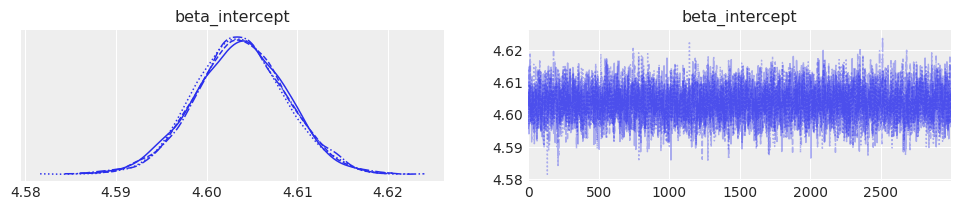

In [35]:
az.plot_trace(trace, var_names=["beta_intercept"])
plt.savefig("beta_intercept.png")

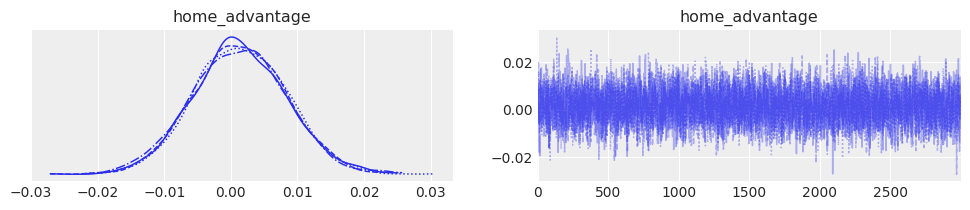

In [33]:
az.plot_trace(trace, var_names=["home_advantage"])
plt.savefig('home_advantage.png')

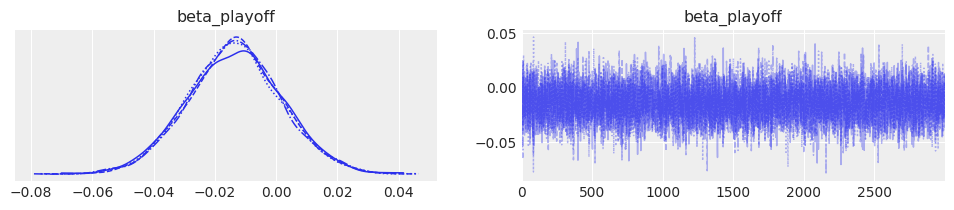

In [34]:
az.plot_trace(trace, var_names=["beta_playoff"])
plt.savefig('impact_playoff.png')

In [36]:
trace_hdi = az.hdi(trace)

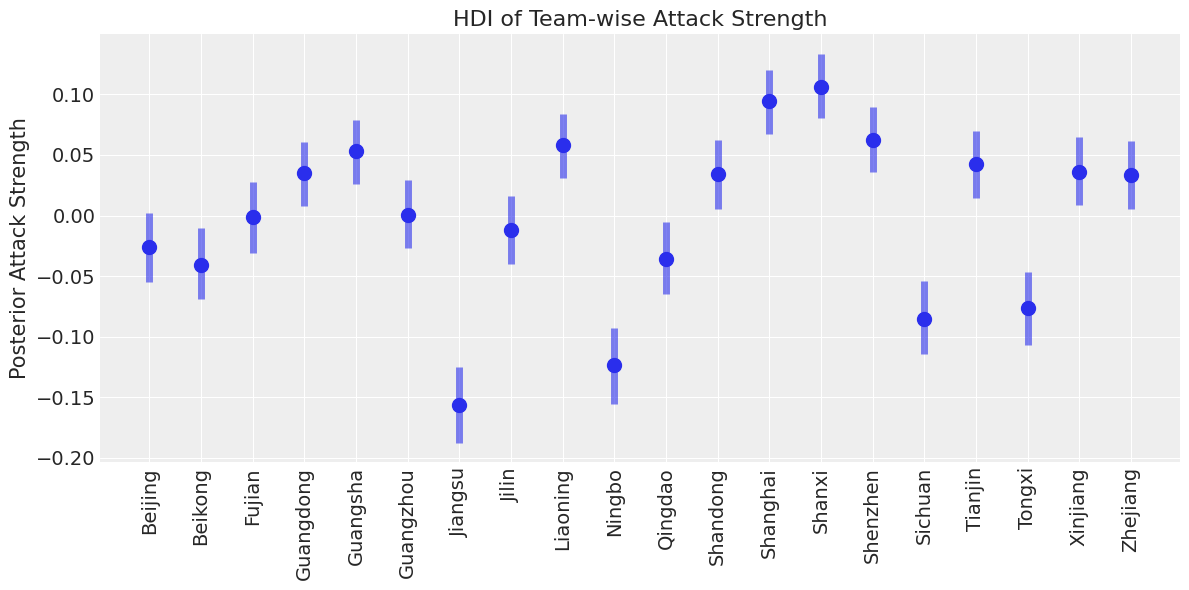

In [41]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["atts"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["atts"].sel({"hdi": "lower"}),
    trace_hdi["atts"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
#ax.set_xlabel("Teams")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel("Posterior Attack Strength")
ax.set_title("HDI of Team-wise Attack Strength")

plt.tight_layout()
plt.savefig('team_att.png')

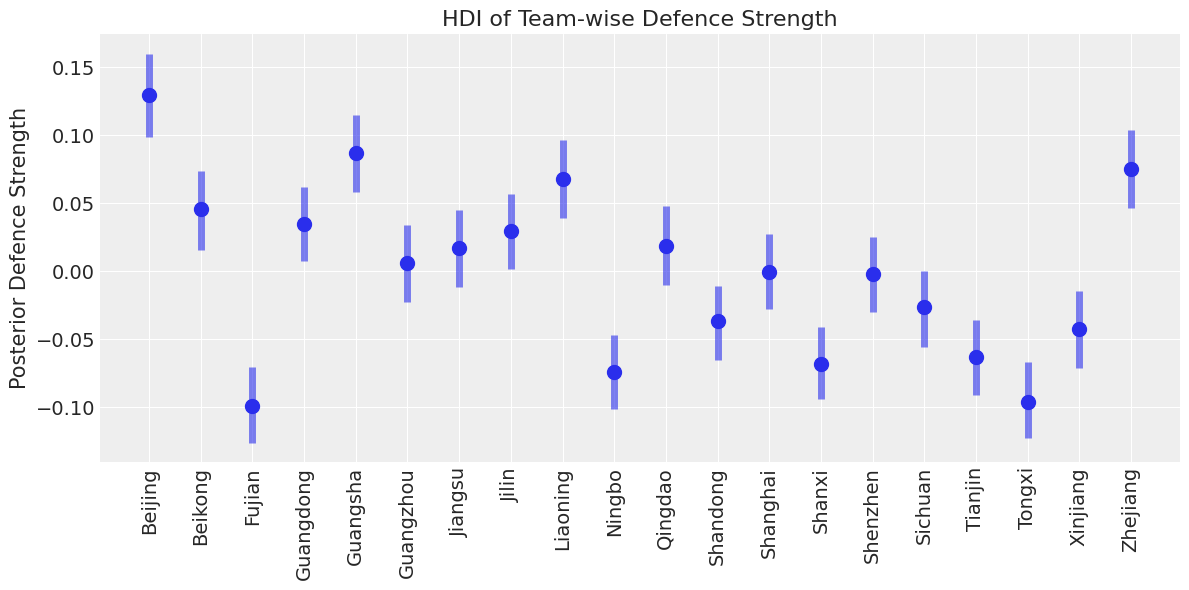

In [42]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["defs"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["defs"].sel({"hdi": "lower"}),
    trace_hdi["defs"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
#ax.set_xlabel("Teams")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel("Posterior Defence Strength")
ax.set_title("HDI of Team-wise Defence Strength")

plt.tight_layout()
plt.savefig('team_def.png')

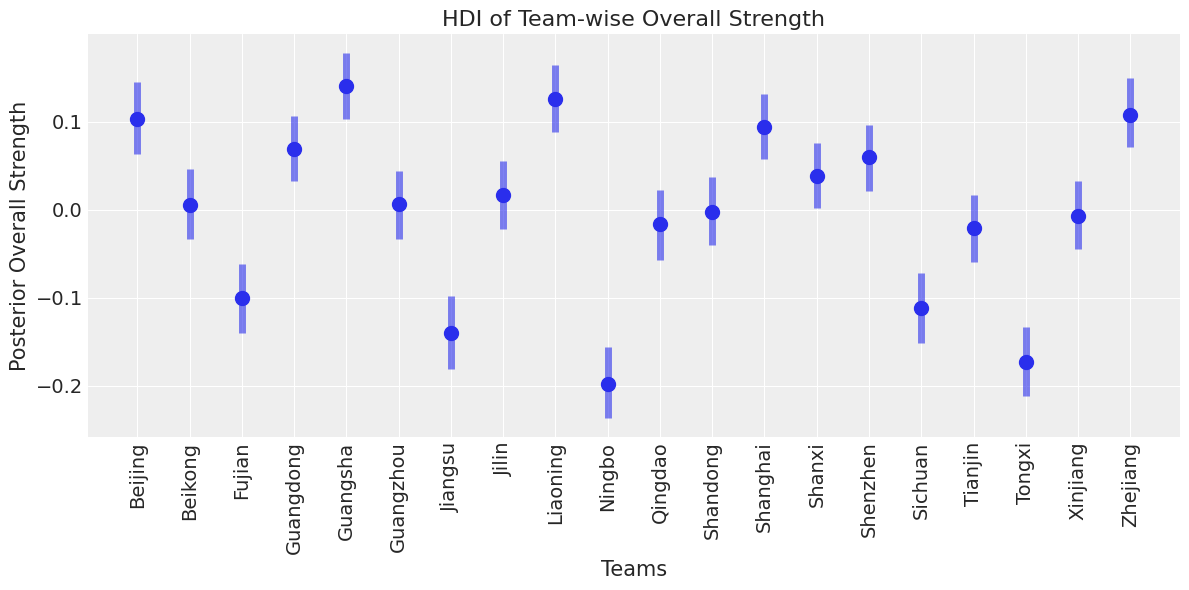

In [43]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["strengths"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["strengths"].sel({"hdi": "lower"}),
    trace_hdi["strengths"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel("Posterior Overall Strength")
ax.set_title("HDI of Team-wise Overall Strength")

plt.tight_layout()
plt.savefig('team_strength.png')